In [1]:
import torch
import numpy as np
import ase.io
import tqdm

import sys
sys.path.append('../code/')
from code_pytorch import *
from utilities import *
from miscellaneous import ClebschGordan

from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt
import time

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model
from rascal.utils import FPSFilter

In [2]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
LAMBDA_MAX = 5
HYPERS = {
    'soap_type' : 'PowerSpectrum',
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO',
    'compute_gradients' : True
    
}

train_subset = '0:10000'
test_subset = '10000:11000'

METHANE_PATH = '../methane.extxyz'
N_MEASUREMENTS = 5

In [3]:
train_structures = process_structures(ase.io.read(METHANE_PATH , index=train_subset))
test_structures = process_structures(ase.io.read(METHANE_PATH , index=test_subset))

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

test_forces = [structure.arrays["forces"] for structure in test_structures]
test_forces = np.concatenate(test_forces, axis = 0) * FORCE_FACTOR

In [4]:
soap = SphericalInvariants(**HYPERS)
train_managers = soap.transform(train_structures)

In [5]:
n_sparse = {1:100, 6:100}
compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(train_managers)

zeta = 2
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
KNM = kernel(train_managers, X_sparse)
#KNM_down = kernel(train_managers, X_sparse)
#KNM = np.vstack([KNM, KNM_down])
model = train_gap_model(kernel, train_structures, KNM, X_sparse, train_energies, {1: 0.0, 6: 0.0}, 
                        lambdas = [1.0, 0.0], jitter=1e-13)


The number of pseudo points selected by central atom species is: {1: 100, 6: 100}
Selecting species: 1
Selecting species: 6


In [7]:
a = compressor.select_and_filter(train_managers)

The number of pseudo points selected by central atom species is: {1: 100, 6: 100}
Selecting species: 1
Selecting species: 6


In [18]:
managers_test = soap.transform(test_structures)
predictions_energies = model.predict(managers_test)
predictions_forces = model.predict_forces(managers_test)

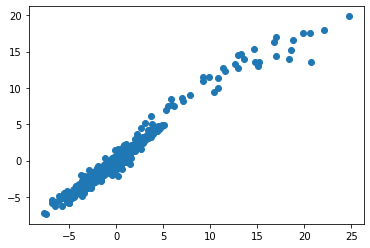

In [19]:
plt.plot(test_energies, predictions_energies, 'o')
plt.show()

(5000, 3)
(5000, 3)


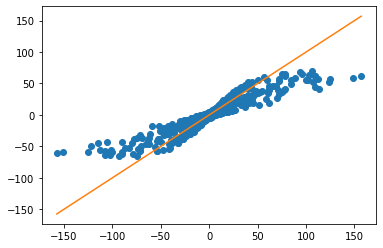

In [20]:
print(predictions_forces.shape)
print(test_forces.shape)
plt.plot(test_forces.reshape(-1), predictions_forces.reshape(-1), 'o')
min_pos = np.min(test_forces)
max_pos = np.max(test_forces)
plt.plot([min_pos, max_pos], [min_pos, max_pos])
plt.show()

In [ ]:
print(X_sparse.)